## Q.91. K-meansによる減色処理 (Step.1) 色の距離によるクラス分類

*imori.jpg*をK-meansを用いた減色処理せよ。

減色処理はQ.6でも扱ったが、Q.6では予め決めた色に減色した。ここで扱うのはK-meansを用いて動的に減色する色を決定する。

アルゴリズムは,
1. 画像からランダムにK個のRGB成分をサンプリングする。（これをクラスと呼ぶことにする。）
2. 画像のそれぞれの画素に対して色の距離が最小となるクラスのインデックスを割り振る。

```bash
色の距離 dis = sqrt( (R-R')^2 + (G-G')^2 + (B-B')^2)
```
3. 各インデックスに対応する色成分の平均をRGBそれぞれに対して取り、新たなクラスとする。
4. 元のクラスと新しいクラスが全く同じならK-meansを終了する。そうでなければ、新しいクラスを元クラスとして2-3を繰り返す。
5. 元画像の各画素で色の距離が最小となるクラスのRGBを割り当てる。

ここでは1-2を実装せよ。
- クラス数はk=5とする
- ここでは画像をreshape((HxW, 3))にreshapeすると扱いやすくなる。
- 1においてはnp.random.seed(0)として、np.random.choice(np.arrange(画像のWxH), 5, replace=False)
- まずは3-5のループを考えずに実装せよ


```bash
# 最初に選べれた色
[[140. 121. 148.]
 [135. 109. 122.]
 [211. 189. 213.]
 [135.  86.  84.]
 [118.  99.  96.]]
```

最初に選ばれた色との色の距離でクラスのインデックスをつけたもの(アルゴリズム2)。
解答では0-4にインデックスの値をx50にして見やすいようにしている。

|入力 (imori.jpg) |出力(answers/answer_91.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers/answer_91.jpg)|

[[140. 121. 148.]
 [135. 109. 122.]
 [211. 189. 213.]
 [135.  86.  84.]
 [118.  99.  96.]]


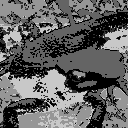

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# k-Means
Class = 5

np.random.seed(0)

img = np.reshape(img, (H*W, -1))

i = np.random.choice(np.arange(H*W), Class, replace=False)
Cs = img[i].copy()

print(Cs)

clss = np.zeros((H*W), dtype=int)

for i in range(H*W):
    dis = np.sqrt(np.sum((Cs - img[i])**2, axis=1))
    clss[i] = np.argmin(dis)


out = np.reshape(clss, (H, W)) * 50
out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.92. K-meansによる減色処理 (Step.2) 減色処理

ここではアルゴリズム3-5も実装せよ。

```bash
# 選ばれた色
[[182.90548706 156.39289856 181.05880737]
 [157.28413391 124.02828979 136.6774292 ]
 [228.36817932 201.76049805 211.80619812]
 [ 91.52492523  57.49259949  56.78660583]
 [121.73962402  88.02610779  96.16177368]]
```

減色処理したもの。塗り絵イラスト風な画像にできる。k=10にすればある程度の色を保持しながらもイラスト風に減色できる。

また、k=5にして*madara.jpg*にも試してみよ。

|入力 (imori.jpg) | 出力(answers/answer_92.jpg) | k=10(answers/answer_92_k10.jpg) |入力2 (madara.jpg) |出力(answers/answer_92_m.jpg) |
|:---:|:---:|:---:|:---:|:---:|
|![](imori.jpg)|![](answers/answer_92.jpg)|![](answers/answer_92_k10.jpg)|![](madara.jpg)|![](answers/answer_92_m.jpg)|

[[182.90548706 156.39289856 181.05880737]
 [157.28413391 124.02828979 136.6774292 ]
 [228.36817932 201.76049805 211.80619812]
 [ 91.52492523  57.49259949  56.78660583]
 [121.73962402  88.02610779  96.16177368]]


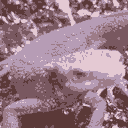

In [2]:
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# k-Means
Class = 5

np.random.seed(0)

img = np.reshape(img, (H*W, -1))


i = np.random.choice(np.arange(H*W), Class, replace=False)
Cs = img[i].copy()


while True:

    clss = np.zeros((H*W), dtype=int)
    
    for i in range(H*W):
        dis = np.sqrt(np.sum((Cs - img[i])**2, axis=1))
        clss[i] = np.argmin(dis)

    Cs_tmp = np.zeros((Class, 3))
    
    for i in range(Class):
        Cs_tmp[i] = np.mean(img[clss==i], axis=0)

    if (Cs == Cs_tmp).all():
        break
    else:
        Cs = Cs_tmp.copy()

out = np.zeros((H*W, 3), dtype=np.float32)
        
for i in range(Class):
    out[clss == i] = Cs[i]

print(Cs)
    
out[out < 0] = 0
out[out > 255] = 255
out = np.reshape(out, (H, W, 3))
out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.93. 機械学習の学習データの用意 (Step.1) IoUの計算

ここから機械学習で用いる学習データの準備を行う。

最終的にはイモリの顔か否かを判別する識別器を作りたい。そのためにはイモリの顔の画像とイモリの顔以外の画像が必要になる。それらを用意するためのプログラムを作成する。

そのためにはイモリの顔周辺を一枚の画像から切り抜く必要がある。
そこで一つの矩形を設定して(GT: Ground-truth, 正解と呼ぶ)、ランダムに切り抜いた矩形がGTとある程度重なっていれば、イモリの顔となる。

その重なり具合を計算するのが、IoU: Intersection over unionであり、次式で計算される。

```bash
R1...Ground-truthの領域 , R2...切り抜いた矩形 , Rol...R1とR2の重なっている領域
IoU = |Rol| / |R1 + R2 - Rol|
```

ここでは、以下の２つの矩形のIoUを計算せよ。

```python
# [x1, y1, x2, y2] x1,y1...矩形の左上のx,y  x2,y2...矩形の右下のx,y
a = np.array((50, 50, 150, 150), dtype=np.float32)

b = np.array((60, 60, 170, 160), dtype=np.float32)
```

答え

```bash
0.627907
```

In [3]:
# [x1, y1, x2, y2]
a = np.array((50, 50, 150, 150), dtype=np.float32)

b = np.array((60, 60, 170, 160), dtype=np.float32)

def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = iou_x2 - iou_x1
    iou_h = iou_y2 - iou_y1
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)

    return iou

print(iou(a, b))

0.627907


## Q.94. 機械学習の学習データの用意 (Step.2) ランダムクラッピング

次に、*imori_1.jpg*からランダムに画像を切り抜いて(cropping, クラッピングと呼ぶ)学習データを作成する。

ここでは画像から60x60のサイズの矩形をランダムに200個切り抜け。

ただし、以下の条件を満たせ。
1. np.random.seed(0)として、切り抜く矩形の左上のx1 = np.random.randint(W-60), y1=np.random.randint(H-60)で求めよ。
2. GT (gt = np.array((47, 41, 129, 103), dtype=np.float32))とのIoUが0.5以上の時はその矩形に教師ラベル1, 0.5未満の場合はラベル0を与えよ。

答えは、ラベル1の矩形を赤、ラベル0の矩形を青、GTを緑にしている。
これでイモリの顔の画像、それ以外の画像を簡易的に用意できた。

|入力 (imori_1.jpg) |出力(answers/answer_94.jpg)|
|:---:|:---:|
|![](imori_1.jpg)|![](answers/answer_94.jpg)|

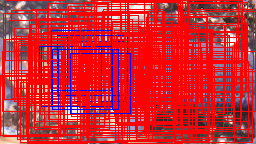

In [4]:
np.random.seed(0)

# read image
img = cv2.imread("imori_1.jpg")
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

gt = np.array((47, 41, 129, 103), dtype=int)

cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), (0,255,0), 1)

def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = max(iou_x2 - iou_x1, 0)
    iou_h = max(iou_y2 - iou_y1, 0)
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)
    return iou


# crop and create database
Crop_num = 200
L = 60

for i in range(Crop_num):
    x1 = np.random.randint(W-L)
    y1 = np.random.randint(H-L)
    x2 = x1 + L
    y2 = y1 + L
    crop = np.array((x1, y1, x2, y2))

    _iou = iou(gt, crop)

    if _iou >= 0.5:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)
        label = 1
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)
        label = 0

display(Image.fromarray(img))

## Q.95. ニューラルネットワーク (Step.1) ディープラーニングにする

ここでは識別器としてニューラルネットワークを用いる。
これは現在流行っているディープラーニングである。


入力層、中間層(ユニット数:64)、出力層(1)のネットワークは次のようにプログラムできる。これは、排他的論理和を実現するネットワークである。プログラムに関しては https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 を参照せよ。

```python
import numpy as np

np.random.seed(0)

class NN:
    def __init__(self, ind=2, w=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w])
        self.b1 = np.random.normal(0, 1, [w])
        self.wout = np.random.normal(0, 1, [w, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.out = sigmoid(np.dot(self.z2, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_En = En #np.array([En for _ in range(t.shape[0])])
        grad_wout = np.dot(self.z2.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout#np.expand_dims(grad_wout, axis=-1)
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u1 = np.dot(En, self.wout.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

train_x = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
train_t = np.array([[0], [1], [1], [0]], dtype=np.float32)

nn = NN(ind=train_x.shape[1])

# train
for i in range(1000):
    nn.forward(train_x)
    nn.train(train_x, train_t)

# test
for j in range(4):
    x = train_x[j]
    t = train_t[j]
    print("in:", x, "pred:", nn.forward(x))
```

ここでは、中間層(ユニット数:64)をもう一層増やし、学習・テストを行え。


答え

```bash
in: [0. 0.] pred: [0.03724313]
in: [0. 1.] pred: [0.95885516]
in: [1. 0.] pred: [0.9641076]
in: [1. 1.] pred: [0.03937037]
```

In [5]:
import numpy as np

np.random.seed(0)


class NN:
    def __init__(self, ind=2, w=64, w2=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w])
        self.b1 = np.random.normal(0, 1, [w])
        self.w2 = np.random.normal(0, 1, [w, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2
        
        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

train_x = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
train_t = np.array([[0], [1], [1], [0]], dtype=np.float32)

nn = NN()

# train
for i in range(5000):
    nn.forward(train_x)
    #print("ite>>", i, 'y >>', nn.forward(train_x))
    nn.train(train_x, train_t)

# test
for j in range(4):
    x = train_x[j]
    t = train_t[j]
    print("in:", x, "pred:", nn.forward(x))

in: [0. 0.] pred: [0.02112243]
in: [0. 1.] pred: [0.97690913]
in: [1. 0.] pred: [0.97987911]
in: [1. 1.] pred: [0.02191621]


## Q.96. ニューラルネットワーク (Step.2) 学習

ここでは、Q.94で用意した学習データ200のHOG特徴量を入力として、Q.95で作成したニューラルネットを学習せよ。

ここでは、学習データに対してAccuracyを計算せよ。ただし、出力(予測確率)が0.5以上で予測ラベルが1、0.5未満で予測ラベルは0としてAccuracyを計算せよ。
学習のハイパーパラメータは、下記の通り。
- 学習率 lr= 0.01
- 学習回数 epch=10000
- 切り抜いた画像を32x32にリサイズして、HOG特徴量を取得せよ。(HOGは8x8を1セルとする。)

```bash
Accuracy >> 1.0 (200.0 / 200)
```

In [6]:
import cv2
import numpy as np

np.random.seed(0)

# read image
img = cv2.imread("imori_1.jpg")
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

gt = np.array((47, 41, 129, 103), dtype=np.float32)

#cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), (0,255,255), 1)

def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = max(iou_x2 - iou_x1, 0)
    iou_h = max(iou_y2 - iou_y1, 0)
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)
    return iou


def hog(gray):
    h, w = gray.shape
    # Magnitude and gradient
    gray = np.pad(gray, (1, 1), 'edge')

    gx = gray[1:h+1, 2:] - gray[1:h+1, :w]
    gy = gray[2:, 1:w+1] - gray[:h, 1:w+1]
    gx[gx == 0] = 0.000001

    mag = np.sqrt(gx ** 2 + gy ** 2)
    gra = np.arctan(gy / gx)
    gra[gra<0] = np.pi / 2 + gra[gra < 0] + np.pi / 2

    # Gradient histogram
    gra_n = np.zeros_like(gra, dtype=int)

    d = np.pi / 9
    for i in range(9):
        gra_n[np.where((gra >= d * i) & (gra <= d * (i+1)))] = i

    N = 8
    HH = h // N
    HW = w // N
    Hist = np.zeros((HH, HW, 9), dtype=np.float32)
    for y in range(HH):
        for x in range(HW):
            for j in range(N):
                for i in range(N):
                    Hist[y, x, gra_n[y*4+j, x*4+i]] += mag[y*4+j, x*4+i]
                
    ## Normalization
    C = 3
    eps = 1
    for y in range(HH):
        for x in range(HW):
            #for i in range(9):
            Hist[y, x] /= np.sqrt(np.sum(Hist[max(y-1,0):min(y+2, HH), max(x-1,0):min(x+2, HW)] ** 2) + eps)

    return Hist

def resize(img, h, w):
    _h, _w  = img.shape
    ah = 1. * h / _h
    aw = 1. * w / _w
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / ah)
    x = (x / aw)

    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _h-2)

    dx = x - ix
    dy = y - iy
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out


class NN:
    def __init__(self, ind=2, w=64, w2=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w])
        self.b1 = np.random.normal(0, 1, [w])
        self.w2 = np.random.normal(0, 1, [w, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2
        
        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

# crop and create database

Crop_num = 200
L = 60
H_size = 32
F_n = ((H_size // 8) ** 2) * 9

db = np.zeros((Crop_num, F_n+1))

for i in range(Crop_num):
    x1 = np.random.randint(W-L)
    y1 = np.random.randint(H-L)
    x2 = x1 + L
    y2 = y1 + L
    crop = np.array((x1, y1, x2, y2))

    _iou = np.zeros((3,))
    _iou[0] = iou(gt, crop)
    #_iou[1] = iou(gt2, crop)
    #_iou[2] = iou(gt3, crop)

    if _iou.max() >= 0.5:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)
        label = 1
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)
        label = 0

    crop_area = gray[y1:y2, x1:x2]
    crop_area = resize(crop_area, H_size, H_size)
    _hog = hog(crop_area)
    
    db[i, :F_n] = _hog.ravel()
    db[i, -1] = label

# train neural network
nn = NN(ind=F_n, lr=0.01)
for i in range(10000):
    nn.forward(db[:, :F_n])
    nn.train(db[:, :F_n], db[:, -1][..., None])

# test
success_pred = 0.
for data in db:
    t = data[-1]
    prob = nn.forward(data[:F_n])
    pred = 1 if prob >= 0.5 else 0
    if t == pred:
        success_pred += 1

accuracy = success_pred / len(db)

print("Accuracy >> {} ({} / {})".format(accuracy, success_pred, len(db)))

Accuracy >> 1.0 (200.0 / 200)


## Q.97. 簡単な物体検出 (Step.1) スライディングウィンドウ + HOG

ここから物体検出を行う。

物体検出とは、画像中でどこに何が写っているかを出力するタスクである。
例えば、画像の[x1, y1, x2, y2]の位置に犬がいるなど。
このような物体を囲む矩形のことをBounding-box(バウンディングボックス)と呼ぶ。

ここでは簡単な物体検出のアルゴリズムを作成する。

1. 画像の左上からスライディングウィンドウを行う。
2. 各画像の位置について、注目位置を中心に複数の矩形を用意する。
3. それぞれの矩形に対応する画像を切り抜いて、特徴抽出(HOG, SIFTなど)を行う。
4. 識別機(CNN, SVMなど)に掛けて各矩形が物体か否かを判別する。

これである程度の物体と矩形の座標が得られる。現在は物体検出はディープラーニングによる手法(Faster R-CNN, YOLO, SSDなど)が主流であるが、ディープラーニングが流行る前まではこのようなスライディングウィンドウの手法が主流であった。今回は検出の基礎を学ぶため、スライディングウィンドウを扱う。

ここでは1-3を実装する。

*imori_many.jpg*に対してイモリの顔検出を行う。
条件は以下。
- 矩形は下記のものを用いる。
```python
# [h, w]
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)
```
- スライドは4ピクセルおきに行う。(1ピクセルでもいいが、計算が多くなって処理が長くなってしまう。)
- 矩形が画像サイズをはみ出る場合は、はみ出ないように変形する。
- 矩形部分を切り抜いたら、その部分を32x32にリサイズする。
- HOG特徴量の取得は8x8を1セルとする。

In [7]:
import cv2
import numpy as np

np.random.seed(0)

# read image
img = cv2.imread("imori_1.jpg")
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

gt = np.array((47, 41, 129, 103), dtype=int)

cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), (0,255,255), 1)


def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = max(iou_x2 - iou_x1, 0)
    iou_h = max(iou_y2 - iou_y1, 0)
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)
    return iou


def hog(gray):
    h, w = gray.shape
    # Magnitude and gradient
    gray = np.pad(gray, (1, 1), 'edge')

    gx = gray[1:h+1, 2:] - gray[1:h+1, :w]
    gy = gray[2:, 1:w+1] - gray[:h, 1:w+1]
    gx[gx == 0] = 0.000001

    mag = np.sqrt(gx ** 2 + gy ** 2)
    gra = np.arctan(gy / gx)
    gra[gra<0] = np.pi / 2 + gra[gra < 0] + np.pi / 2

    # Gradient histogram
    gra_n = np.zeros_like(gra, dtype=int)

    d = np.pi / 9
    for i in range(9):
        gra_n[np.where((gra >= d * i) & (gra <= d * (i+1)))] = i

    N = 8
    HH = h // N
    HW = w // N
    Hist = np.zeros((HH, HW, 9), dtype=np.float32)
    for y in range(HH):
        for x in range(HW):
            for j in range(N):
                for i in range(N):
                    Hist[y, x, gra_n[y*4+j, x*4+i]] += mag[y*4+j, x*4+i]
                
    ## Normalization
    C = 3
    eps = 1
    for y in range(HH):
        for x in range(HW):
            #for i in range(9):
            Hist[y, x] /= np.sqrt(np.sum(Hist[max(y-1,0):min(y+2, HH), max(x-1,0):min(x+2, HW)] ** 2) + eps)

    return Hist

def resize(img, h, w):
    _h, _w  = img.shape
    ah = 1. * h / _h
    aw = 1. * w / _w
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / ah)
    x = (x / aw)

    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _h-2)

    dx = x - ix
    dy = y - iy
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out

# read detect target image
img2 = cv2.imread("imori_many.jpg")
H2, W2, C2 = img2.shape

# Resize size
H_size = 32
# HOG Feature vector size
F_n = ((H_size // 8) ** 2) * 9

# Grayscale
gray2 = 0.2126 * img2[..., 2] + 0.7152 * img2[..., 1] + 0.0722 * img2[..., 0]

# [h, w]
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)


# sliding window
for y in range(0, H2, 4):
    for x in range(0, W2, 4):
        for rec in recs:
            dh = int(rec[0] // 2)
            dw = int(rec[1] // 2)
            x1 = max(x-dw, 0)
            x2 = min(x+dw, W2)
            y1 = max(y-dh, 0)
            y2 = min(y+dh, H2)
            region = gray2[max(y-dh,0):min(y+dh,H2), max(x-dw,0):min(x+dw,W2)]
            region = resize(region, H_size, H_size)
            region_hog = hog(region).ravel()

## Q.98. 簡単な物体検出 (Step.2) スライディングウィンドウ + NN

*imori_many.jpg*に対して、ここではQ.97で求めた各矩形のHOG特徴量を入力として、Q.96で学習したニューラルネットでイモリの顔か否かを識別せよ。

ここでスコア(予測確率)が0.7以上の矩形を描画せよ。

答え
検出された矩形 [x1, y1, x2, y2, score]

```bash
[[ 27.           0.          69.          21.           0.74268049]
[ 31.           0.          73.          21.           0.89631011]
[ 52.           0.         108.          36.           0.84373157]
[165.           0.         235.          43.           0.73741703]
[ 55.           0.          97.          33.           0.70987278]
[165.           0.         235.          47.           0.92333214]
[169.           0.         239.          47.           0.84030839]
[ 51.           0.          93.          37.           0.84301022]
[168.           0.         224.          44.           0.79237294]
[165.           0.         235.          51.           0.86038564]
[ 51.           0.          93.          41.           0.85151915]
[ 48.           0.         104.          56.           0.73268318]
[168.           0.         224.          56.           0.86675902]
[ 43.          15.          85.          57.           0.93562483]
[ 13.          37.          83.         107.           0.77192307]
[180.          44.         236.         100.           0.82054873]
[173.          37.         243.         107.           0.8478805 ]
[177.          37.         247.         107.           0.87183443]
[ 24.          68.          80.         124.           0.7279032 ]
[103.          75.         145.         117.           0.73725153]
[104.          68.         160.         124.           0.71314282]
[ 96.          72.         152.         128.           0.86269195]
[100.          72.         156.         128.           0.98826957]
[ 25.          69.          95.         139.           0.73449174]
[100.          76.         156.         132.           0.74963093]
[104.          76.         160.         132.           0.96620193]
[ 75.          91.         117.         133.           0.80533424]
[ 97.          77.         167.         144.           0.7852362 ]
[ 97.          81.         167.         144.           0.70371708]]
```

|入力 (imori_many.jpg) |出力(answers/answer_98.jpg)|
|:---:|:---:|
|![](imori_many.jpg)|![](answers/answer_98.jpg)|

In [8]:
import cv2
import numpy as np

np.random.seed(0)

# read image
img = cv2.imread("imori_1.jpg")
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

gt = np.array((47, 41, 129, 103), dtype=int)

cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), (0,255,255), 1)

def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = max(iou_x2 - iou_x1, 0)
    iou_h = max(iou_y2 - iou_y1, 0)
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)
    return iou


def hog(gray):
    h, w = gray.shape
    # Magnitude and gradient
    gray = np.pad(gray, (1, 1), 'edge')

    gx = gray[1:h+1, 2:] - gray[1:h+1, :w]
    gy = gray[2:, 1:w+1] - gray[:h, 1:w+1]
    gx[gx == 0] = 0.000001

    mag = np.sqrt(gx ** 2 + gy ** 2)
    gra = np.arctan(gy / gx)
    gra[gra<0] = np.pi / 2 + gra[gra < 0] + np.pi / 2

    # Gradient histogram
    gra_n = np.zeros_like(gra, dtype=int)

    d = np.pi / 9
    for i in range(9):
        gra_n[np.where((gra >= d * i) & (gra <= d * (i+1)))] = i

    N = 8
    HH = h // N
    HW = w // N
    Hist = np.zeros((HH, HW, 9), dtype=np.float32)
    for y in range(HH):
        for x in range(HW):
            for j in range(N):
                for i in range(N):
                    Hist[y, x, gra_n[y*4+j, x*4+i]] += mag[y*4+j, x*4+i]
                
    ## Normalization
    C = 3
    eps = 1
    for y in range(HH):
        for x in range(HW):
            #for i in range(9):
            Hist[y, x] /= np.sqrt(np.sum(Hist[max(y-1,0):min(y+2, HH), max(x-1,0):min(x+2, HW)] ** 2) + eps)

    return Hist

def resize(img, h, w):
    _h, _w  = img.shape
    ah = 1. * h / _h
    aw = 1. * w / _w
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / ah)
    x = (x / aw)

    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _h-2)

    dx = x - ix
    dy = y - iy
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out


class NN:
    def __init__(self, ind=2, w=64, w2=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w])
        self.b1 = np.random.normal(0, 1, [w])
        self.w2 = np.random.normal(0, 1, [w, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2
        
        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

# crop and create database

Crop_num = 200
L = 60
H_size = 32
F_n = ((H_size // 8) ** 2) * 9

db = np.zeros((Crop_num, F_n+1))

for i in range(Crop_num):
    x1 = np.random.randint(W-L)
    y1 = np.random.randint(H-L)
    x2 = x1 + L
    y2 = y1 + L
    crop = np.array((x1, y1, x2, y2))

    _iou = iou(gt, crop)

    if _iou >= 0.5:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)
        label = 1
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)
        label = 0

    crop_area = gray[y1:y2, x1:x2]
    crop_area = resize(crop_area, H_size, H_size)
    _hog = hog(crop_area)
    
    db[i, :F_n] = _hog.ravel()
    db[i, -1] = label

## train neural network
nn = NN(ind=F_n, lr=0.01)
for i in range(10000):
    nn.forward(db[:, :F_n])
    nn.train(db[:, :F_n], db[:, -1][..., None])


# read detect target image
img2 = cv2.imread("imori_many.jpg")
H2, W2, C2 = img2.shape

# Grayscale
gray2 = 0.2126 * img2[..., 2] + 0.7152 * img2[..., 1] + 0.0722 * img2[..., 0]

# [h, w]
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=int)

detects = np.ndarray((0, 5), dtype=np.float32)

# sliding window
for y in range(0, H2, 4):
    for x in range(0, W2, 4):
        for rec in recs:
            dh = int(rec[0] // 2)
            dw = int(rec[1] // 2)
            x1 = max(x-dw, 0)
            x2 = min(x+dw, W2)
            y1 = max(y-dh, 0)
            y2 = min(y+dh, H2)
            region = gray2[max(y-dh,0):min(y+dh,H2), max(x-dw,0):min(x+dw,W2)]
            region = resize(region, H_size, H_size)
            region_hog = hog(region).ravel()

            score = nn.forward(region_hog)
            if score >= 0.7:
                cv2.rectangle(img2, (x1, y1), (x2, y2), (0,0,255), 1)
                detects = np.vstack((detects, np.array((x1, y1, x2, y2, score))))

print(detects)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

## Q.99. 簡単な物体検出 (Step.3) Non-Maximum Suppression

Q.97であらかたの検出はできたが、このままではBrounding-boxの数が多すぎて、ここから何かしらの処理に繋げるには不便である。
そこで、NMS: Non-maximum suppressionという手法を用いて矩形の数を減らす。

NMSとはスコアの高いBounding-boxのみを残す手法であり、アルゴリズムは以下の通り。

1. Boundinb-boxの集合Bをスコアが高い順にソートする。
2. スコアが最大のものをb0とする。
3. b0と他のBounding-boxのIoUを計算する。IoUが閾値t以上のBounding-boxをBから削除する。B0は出力する集合Rに加え、Bから削除する。
4. 2-3をBがなくなるまで行う。
5. Rを出力する。

Q.98にNMS(閾値t=0.25)を組み込み、出力を描画せよ。
解答では検出の左上にスコアも加えている。

精度はともあれ、これで検出の一連の流れが完了した。
ニューラルネットの学習を増やしたりすることで、検出の精度は更に向上ができる。

|入力 (imori_many.jpg) |NMS前(answers/answer_98.jpg)|NMS後(answers/answer_99.jpg)|
|:---:|:---:|:---:|
|![](imori_many.jpg)|![](answers/answer_98.jpg)|![](answers/answer_99.jpg)|

In [ ]:
import cv2
import numpy as np

np.random.seed(0)

# read image
img = cv2.imread("imori_1.jpg")
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

gt = np.array((47, 41, 129, 103), dtype=int)

cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), (0,255,255), 1)

def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = max(iou_x2 - iou_x1, 0)
    iou_h = max(iou_y2 - iou_y1, 0)
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)
    return iou


def hog(gray):
    h, w = gray.shape
    # Magnitude and gradient
    gray = np.pad(gray, (1, 1), 'edge')

    gx = gray[1:h+1, 2:] - gray[1:h+1, :w]
    gy = gray[2:, 1:w+1] - gray[:h, 1:w+1]
    gx[gx == 0] = 0.000001

    mag = np.sqrt(gx ** 2 + gy ** 2)
    gra = np.arctan(gy / gx)
    gra[gra<0] = np.pi / 2 + gra[gra < 0] + np.pi / 2

    # Gradient histogram
    gra_n = np.zeros_like(gra, dtype=int)

    d = np.pi / 9
    for i in range(9):
        gra_n[np.where((gra >= d * i) & (gra <= d * (i+1)))] = i

    N = 8
    HH = h // N
    HW = w // N
    Hist = np.zeros((HH, HW, 9), dtype=np.float32)
    for y in range(HH):
        for x in range(HW):
            for j in range(N):
                for i in range(N):
                    Hist[y, x, gra_n[y*4+j, x*4+i]] += mag[y*4+j, x*4+i]
                
    ## Normalization
    C = 3
    eps = 1
    for y in range(HH):
        for x in range(HW):
            #for i in range(9):
            Hist[y, x] /= np.sqrt(np.sum(Hist[max(y-1,0):min(y+2, HH), max(x-1,0):min(x+2, HW)] ** 2) + eps)

    return Hist

def resize(img, h, w):
    _h, _w  = img.shape
    ah = 1. * h / _h
    aw = 1. * w / _w
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / ah)
    x = (x / aw)

    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _h-2)

    dx = x - ix
    dy = y - iy
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out




# crop and create database

Crop_num = 200
L = 60
H_size = 32
F_n = ((H_size // 8) ** 2) * 9

db = np.zeros((Crop_num, F_n+1))

for i in range(Crop_num):
    x1 = np.random.randint(W-L)
    y1 = np.random.randint(H-L)
    x2 = x1 + L
    y2 = y1 + L
    crop = np.array((x1, y1, x2, y2))

    _iou = iou(gt, crop)

    if _iou >= 0.5:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)
        label = 1
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)
        label = 0

    crop_area = gray[y1:y2, x1:x2]
    crop_area = resize(crop_area, H_size, H_size)
    _hog = hog(crop_area)
    
    db[i, :F_n] = _hog.ravel()
    db[i, -1] = label


class NN:
    def __init__(self, ind=2, w=64, w2=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w])
        self.b1 = np.random.normal(0, 1, [w])
        self.w2 = np.random.normal(0, 1, [w, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2
        
        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

def sigmoid(x):
    return 1. / (1. + np.exp(-x))
    

## training neural network
nn = NN(ind=F_n, lr=0.01)
for i in range(10000):
    nn.forward(db[:, :F_n])
    nn.train(db[:, :F_n], db[:, -1][..., None])


# read detect target image
img2 = cv2.imread("imori_many.jpg")
H2, W2, C2 = img2.shape

# Grayscale
gray2 = 0.2126 * img2[..., 2] + 0.7152 * img2[..., 1] + 0.0722 * img2[..., 0]

# [h, w]
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)

detects = np.ndarray((0, 5), dtype=np.float32)

# sliding window
for y in range(0, H2, 4):
    for x in range(0, W2, 4):
        for rec in recs:
            dh = int(rec[0] // 2)
            dw = int(rec[1] // 2)
            x1 = max(x-dw, 0)
            x2 = min(x+dw, W2)
            y1 = max(y-dh, 0)
            y2 = min(y+dh, H2)
            region = gray2[max(y-dh,0):min(y+dh,H2), max(x-dw,0):min(x+dw,W2)]
            region = resize(region, H_size, H_size)
            region_hog = hog(region).ravel()

            score = nn.forward(region_hog)
            if score >= 0.7:
                #cv2.rectangle(img2, (x1, y1), (x2, y2), (0,0,255), 1)
                detects = np.vstack((detects, np.array((x1, y1, x2, y2, score))))


# Non-maximum suppression
def nms(_bboxes, iou_th=0.5, select_num=None, prob_th=None):
    #
    # Non Maximum Suppression
    #
    # Argument
    #  bboxes(Nx5) ... [bbox-num, 5(leftTopX,leftTopY,w,h, score)]
    #  iou_th([float]) ... threshold for iou between bboxes.
    #  select_num([int]) ... max number for choice bboxes. If None, this is unvalid.
    #  prob_th([float]) ... probability threshold to choice. If None, this is unvalid.
    # Return
    #  inds ... choced indices for bboxes
    #

    bboxes = _bboxes.copy()
    
    bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
    bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]
    
    # Sort by bbox's score. High -> Low
    sort_inds = np.argsort(bboxes[:, -1])[::-1]

    processed_bbox_ind = []
    return_inds = []

    unselected_inds = sort_inds.copy()
    
    while len(unselected_inds) > 0:
        process_bboxes = bboxes[unselected_inds]
        argmax_score_ind = np.argmax(process_bboxes[::, -1])
        max_score_ind = unselected_inds[argmax_score_ind]
        return_inds += [max_score_ind]
        unselected_inds = np.delete(unselected_inds, argmax_score_ind)

        base_bbox = bboxes[max_score_ind]
        compare_bboxes = bboxes[unselected_inds]
        
        base_x1 = base_bbox[0]
        base_y1 = base_bbox[1]
        base_x2 = base_bbox[2] + base_x1
        base_y2 = base_bbox[3] + base_y1
        base_w = np.maximum(base_bbox[2], 0)
        base_h = np.maximum(base_bbox[3], 0)
        base_area = base_w * base_h

        # compute iou-area between base bbox and other bboxes
        iou_x1 = np.maximum(base_x1, compare_bboxes[:, 0])
        iou_y1 = np.maximum(base_y1, compare_bboxes[:, 1])
        iou_x2 = np.minimum(base_x2, compare_bboxes[:, 2] + compare_bboxes[:, 0])
        iou_y2 = np.minimum(base_y2, compare_bboxes[:, 3] + compare_bboxes[:, 1])
        iou_w = np.maximum(iou_x2 - iou_x1, 0)
        iou_h = np.maximum(iou_y2 - iou_y1, 0)
        iou_area = iou_w * iou_h

        compare_w = np.maximum(compare_bboxes[:, 2], 0)
        compare_h = np.maximum(compare_bboxes[:, 3], 0)
        compare_area = compare_w * compare_h

        # bbox's index which iou ratio over threshold is excluded
        all_area = compare_area + base_area - iou_area
        iou_ratio = np.zeros((len(unselected_inds)))
        iou_ratio[all_area < 0.9] = 0.
        _ind = all_area >= 0.9
        iou_ratio[_ind] = iou_area[_ind] / all_area[_ind]
        
        unselected_inds = np.delete(unselected_inds, np.where(iou_ratio >= iou_th)[0])

    if prob_th is not None:
        preds = bboxes[return_inds][:, -1]
        return_inds = np.array(return_inds)[np.where(preds >= prob_th)[0]].tolist()
        
    # pick bbox's index by defined number with higher score
    if select_num is not None:
        return_inds = return_inds[:select_num]

    return return_inds


detects = detects[nms(detects, iou_th=0.25)]

for d in detects:
    v = list(map(int, d[:4]))
    cv2.rectangle(img2, (v[0], v[1]), (v[2], v[3]), (0,0,255), 1)
    cv2.putText(img2, "{:.2f}".format(d[-1]), (v[0], v[1]+9),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,255), 1)

## Q.100. 簡単な物体検出 (Step.4) 評価 Precision, Recall, F-score, mAP

ついに100問目！！！

ここでは検出の評価指標を実装する。

検出はBounding-boxとそのクラスの２つが一致していないと、精度の評価ができない。
検出の評価指標には、Recall, Precision, F-score, mAPなどが存在する。

### Recall ... 正解の矩形がどれだけ検出できたか。正解をどれだけ網羅できたかを示す。[0,1]の範囲を取り、1が最高。

```bash
G' ... Ground-truthの中で検出のどれかとIoUが閾値t以上となったGround-truthの数。
G ... Ground-truthの矩形の数。
Recall = G' / G
```
### Precision ... 検出がどれだけ正確に行われたかを示す。[0,1]の範囲を取り、1が最高。

```bash
D' ... 検出の中で、Ground-truthのどれかとIoUが閾値t以上となった検出の数。
D ... 検出の数。
Precision = D' / D
```

### F-score ... RecallとPrecisonの調和平均。　２つのバランスを示すもので、[0,1]の範囲を取り、1が最高。

```bash
F-score = 2 * Recall * Precision / (Recall + Precision)
```

文字を検出する文字検出はRecall, Precision, F-scoreで精度を測ることが多い。

### mAP ... Mean Average Precision。物体を検出する物体検出では、mAPで測ることが多い。mAPの計算方法は少し複雑である。

1. 各検出に関してGround-truthとのIoUが閾値t以上かどうかを判断して、表を作成する。
```bash
   Detect | judge
------------------
  detect1 |   1   (1はGround-truthとのIoU>=tとなったもの)
  detect2 |   0   (0はGround-truthとのIoU<tとなったもの)
  detect3 |   1
```
2. mAP = 0として、上から順に見て、judgeが1の時は、見ているものの上すべてに関して、Precisionを計算し、mAPに加算する。
3. 上から順に2を行い、全て行ったら、加算回数でmAPを割る。

以上でmAPが求まる。上の例でいうと、
1. detect1 が1なので、Precisionを求める。Precision = 1/1 = 1なので、mAP = 1
2. detect2 が0なので、無視。
3. detect3 が1なので、Precisionを求める。Precision = 2/3 = 0.67 なので、 mAP = 1 + 0.67 = 1.67
4. mAPに加算したのは計2回なので、mAP = 1.67 / 2 = 0.835
となる。


ここでは、閾値t=0.5として、Recall, Precision, F-score, mAPを算出せよ。
Ground-truthは次とする。
```python
# [x1, y1, x2, y2]
GT = np.array(((27, 48, 95, 110), (101, 75, 171, 138)), dtype=np.float32)
```

ここでは、GTとのIoUが0.5以上の検出を赤、それ以外を青にして描画せよ。

解答
```bash
Recall >> 1.00 (2.0 / 2)
Precision >> 0.25 (2.0 / 8)
F-score >>  0.4
mAP >> 0.0625
```

|入力 (imori_many.jpg) |GT(answers/answer_100_gt.jpg)|出力(answers/answer_100.jpg)|
|:---:|:---:|:---:|
|![](imori_many.jpg)|![](answers/answer_100_gt.jpg)|![](answers/answer_100.jpg)|

In [10]:
import cv2
import numpy as np

np.random.seed(0)

# read image
img = cv2.imread("imori_1.jpg")
H, W, C = img.shape

# Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

gt = np.array((47, 41, 129, 103), dtype=int)

cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), (0,255,255), 1)

def iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    iou_x1 = np.maximum(a[0], b[0])
    iou_y1 = np.maximum(a[1], b[1])
    iou_x2 = np.minimum(a[2], b[2])
    iou_y2 = np.minimum(a[3], b[3])
    iou_w = max(iou_x2 - iou_x1, 0)
    iou_h = max(iou_y2 - iou_y1, 0)
    area_iou = iou_w * iou_h
    iou = area_iou / (area_a + area_b - area_iou)
    return iou


def hog(gray):
    h, w = gray.shape
    # Magnitude and gradient
    gray = np.pad(gray, (1, 1), 'edge')

    gx = gray[1:h+1, 2:] - gray[1:h+1, :w]
    gy = gray[2:, 1:w+1] - gray[:h, 1:w+1]
    gx[gx == 0] = 0.000001

    mag = np.sqrt(gx ** 2 + gy ** 2)
    gra = np.arctan(gy / gx)
    gra[gra<0] = np.pi / 2 + gra[gra < 0] + np.pi / 2

    # Gradient histogram
    gra_n = np.zeros_like(gra, dtype=int)

    d = np.pi / 9
    for i in range(9):
        gra_n[np.where((gra >= d * i) & (gra <= d * (i+1)))] = i

    N = 8
    HH = h // N
    HW = w // N
    Hist = np.zeros((HH, HW, 9), dtype=np.float32)
    for y in range(HH):
        for x in range(HW):
            for j in range(N):
                for i in range(N):
                    Hist[y, x, gra_n[y*4+j, x*4+i]] += mag[y*4+j, x*4+i]
                
    ## Normalization
    C = 3
    eps = 1
    for y in range(HH):
        for x in range(HW):
            #for i in range(9):
            Hist[y, x] /= np.sqrt(np.sum(Hist[max(y-1,0):min(y+2, HH), max(x-1,0):min(x+2, HW)] ** 2) + eps)

    return Hist

def resize(img, h, w):
    _h, _w  = img.shape
    ah = 1. * h / _h
    aw = 1. * w / _w
    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))
    y = (y / ah)
    x = (x / aw)

    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _h-2)

    dx = x - ix
    dy = y - iy
    
    out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]
    out[out>255] = 255

    return out


class NN:
    def __init__(self, ind=2, w=64, w2=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w])
        self.b1 = np.random.normal(0, 1, [w])
        self.w2 = np.random.normal(0, 1, [w, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2
        
        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

def sigmoid(x):
    return 1. / (1. + np.exp(-x))


# crop and create database

Crop_num = 200
L = 60
H_size = 32
F_n = ((H_size // 8) ** 2) * 9

db = np.zeros((Crop_num, F_n+1))

for i in range(Crop_num):
    x1 = np.random.randint(W-L)
    y1 = np.random.randint(H-L)
    x2 = x1 + L
    y2 = y1 + L
    crop = np.array((x1, y1, x2, y2))

    _iou = iou(gt, crop)

    if _iou >= 0.5:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)
        label = 1
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)
        label = 0

    crop_area = gray[y1:y2, x1:x2]
    crop_area = resize(crop_area, H_size, H_size)
    _hog = hog(crop_area)
    
    db[i, :F_n] = _hog.ravel()
    db[i, -1] = label


## training neural network
nn = NN(ind=F_n, lr=0.01)
for i in range(10000):
    nn.forward(db[:, :F_n])
    nn.train(db[:, :F_n], db[:, -1][..., None])


# read detect target image
img2 = cv2.imread("imori_many.jpg")
H2, W2, C2 = img2.shape

# Grayscale
gray2 = 0.2126 * img2[..., 2] + 0.7152 * img2[..., 1] + 0.0722 * img2[..., 0]

# [h, w]
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)

detects = np.ndarray((0, 5), dtype=np.float32)

# sliding window
for y in range(0, H2, 4):
    for x in range(0, W2, 4):
        for rec in recs:
            dh = int(rec[0] // 2)
            dw = int(rec[1] // 2)
            x1 = max(x-dw, 0)
            x2 = min(x+dw, W2)
            y1 = max(y-dh, 0)
            y2 = min(y+dh, H2)
            region = gray2[max(y-dh,0):min(y+dh,H2), max(x-dw,0):min(x+dw,W2)]
            region = resize(region, H_size, H_size)
            region_hog = hog(region).ravel()

            score = nn.forward(region_hog)
            if score >= 0.7:
                #cv2.rectangle(img2, (x1, y1), (x2, y2), (0,0,255), 1)
                detects = np.vstack((detects, np.array((x1, y1, x2, y2, score))))


# Non-maximum suppression
def nms(_bboxes, iou_th=0.5, select_num=None, prob_th=None):
    #
    # Non Maximum Suppression
    #
    # Argument
    #  bboxes(Nx5) ... [bbox-num, 5(leftTopX,leftTopY,w,h, score)]
    #  iou_th([float]) ... threshold for iou between bboxes.
    #  select_num([int]) ... max number for choice bboxes. If None, this is unvalid.
    #  prob_th([float]) ... probability threshold to choice. If None, this is unvalid.
    # Return
    #  inds ... choced indices for bboxes
    #

    bboxes = _bboxes.copy()
    
    bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
    bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]
    
    # Sort by bbox's score. High -> Low
    sort_inds = np.argsort(bboxes[:, -1])[::-1]

    processed_bbox_ind = []
    return_inds = []

    unselected_inds = sort_inds.copy()
    
    while len(unselected_inds) > 0:
        process_bboxes = bboxes[unselected_inds]
        argmax_score_ind = np.argmax(process_bboxes[::, -1])
        max_score_ind = unselected_inds[argmax_score_ind]
        return_inds += [max_score_ind]
        unselected_inds = np.delete(unselected_inds, argmax_score_ind)

        base_bbox = bboxes[max_score_ind]
        compare_bboxes = bboxes[unselected_inds]
        
        base_x1 = base_bbox[0]
        base_y1 = base_bbox[1]
        base_x2 = base_bbox[2] + base_x1
        base_y2 = base_bbox[3] + base_y1
        base_w = np.maximum(base_bbox[2], 0)
        base_h = np.maximum(base_bbox[3], 0)
        base_area = base_w * base_h

        # compute iou-area between base bbox and other bboxes
        iou_x1 = np.maximum(base_x1, compare_bboxes[:, 0])
        iou_y1 = np.maximum(base_y1, compare_bboxes[:, 1])
        iou_x2 = np.minimum(base_x2, compare_bboxes[:, 2] + compare_bboxes[:, 0])
        iou_y2 = np.minimum(base_y2, compare_bboxes[:, 3] + compare_bboxes[:, 1])
        iou_w = np.maximum(iou_x2 - iou_x1, 0)
        iou_h = np.maximum(iou_y2 - iou_y1, 0)
        iou_area = iou_w * iou_h

        compare_w = np.maximum(compare_bboxes[:, 2], 0)
        compare_h = np.maximum(compare_bboxes[:, 3], 0)
        compare_area = compare_w * compare_h

        # bbox's index which iou ratio over threshold is excluded
        all_area = compare_area + base_area - iou_area
        iou_ratio = np.zeros((len(unselected_inds)))
        iou_ratio[all_area < 0.9] = 0.
        _ind = all_area >= 0.9
        iou_ratio[_ind] = iou_area[_ind] / all_area[_ind]
        
        unselected_inds = np.delete(unselected_inds, np.where(iou_ratio >= iou_th)[0])

    if prob_th is not None:
        preds = bboxes[return_inds][:, -1]
        return_inds = np.array(return_inds)[np.where(preds >= prob_th)[0]].tolist()
        
    # pick bbox's index by defined number with higher score
    if select_num is not None:
        return_inds = return_inds[:select_num]

    return return_inds


detects = detects[nms(detects, iou_th=0.25)]


# Evaluation

# [x1, y1, x2, y2]
GT = np.array(((27, 48, 95, 110), (101, 75, 171, 138)), dtype=np.float32)

## Recall, Precision, F-score
iou_th = 0.5

Rs = np.zeros((len(GT)))
Ps = np.zeros((len(detects)))

for i, g in enumerate(GT):
    iou_x1 = np.maximum(g[0], detects[:, 0])
    iou_y1 = np.maximum(g[1], detects[:, 1])
    iou_x2 = np.minimum(g[2], detects[:, 2])
    iou_y2 = np.minimum(g[3], detects[:, 3])
    iou_w = np.maximum(0, iou_x2 - iou_x1)
    iou_h = np.maximum(0, iou_y2 - iou_y1)
    iou_area = iou_w * iou_h
    g_area = (g[2] - g[0]) * (g[3] - g[1])
    d_area = (detects[:, 2] - detects[:, 0]) * (detects[:, 3] - detects[:, 1])
    ious = iou_area / (g_area + d_area - iou_area)
    
    Rs[i] = 1 if len(np.where(ious >= iou_th)[0]) > 0 else 0
    Ps[ious >= iou_th] = 1
    

R = np.sum(Rs) / len(Rs)
P = np.sum(Ps) / len(Ps)
F = (2 * P * R) / (P + R) 

print("Recall >> {:.2f} ({} / {})".format(R, np.sum(Rs), len(Rs)))
print("Precision >> {:.2f} ({} / {})".format(P, np.sum(Ps), len(Ps)))
print("F-score >> ", F)

## mAP
mAP = 0.
for i in range(len(detects)):
    mAP += np.sum(Ps[:i]) / (i + 1) * Ps[i]
mAP /= np.sum(Ps)

print("mAP >>", mAP)

# Display
for i in range(len(detects)):
    v = list(map(int, detects[i, :4]))
    if Ps[i] > 0:
        cv2.rectangle(img2, (v[0], v[1]), (v[2], v[3]), (0,0,255), 1)
    else:
        cv2.rectangle(img2, (v[0], v[1]), (v[2], v[3]), (255,0,0), 1)
    cv2.putText(img2, "{:.2f}".format(detects[i, -1]), (v[0], v[1]+9),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,255), 1)

for g in GT:
    cv2.rectangle(img2, (g[0], g[1]), (g[2], g[3]), (0,255,0), 1)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.